In [113]:
"""
Pls write the full code for a different setup which is structured following Freud psychoanalytical patterns of Id, Ego, SuperEgo + Creativity, Rationality, Emotion.
All of these are routed by the Consciousness which determined which to route the next response to based on predefined logical behavioural routes as well as a relevance scoring system
The result is passed through to a last layer node called Persona which acts as a final rephrase of the complete output to the initial input
Also, each main agent node is a supervisor within its own department where it has a webcrawler agent, a coding agent which can generate code, save and display charts based on given data, and a planner which first thinks step by step, laying out a chain of thought reasoning before processing any given input.
i.e. example functionality: (this is not a predefined flow)
user_input: I'm hungry -> Emotion: 'he needs help'-> id: 'i don't care' -> superego: 'that's bad' -> ego: 'let's help' -> creativity: 'a sandwich' -> rationality: 'open fridge, make sandwich' -> webCrawler: 'sandwich recipes' -> coder: 'chart on hunger decreasing with time after sandwich' -> persona: 'Im here to help, here's web recipe, open fridge, make sandwich, eat, decrease hunger like so.'
"""

"\nPls write the full code for a different setup which is structured following Freud psychoanalytical patterns of Id, Ego, SuperEgo + Creativity, Rationality, Emotion.\nAll of these are routed by the Consciousness which determined which to route the next response to based on predefined logical behavioural routes as well as a relevance scoring system\nThe result is passed through to a last layer node called Persona which acts as a final rephrase of the complete output to the initial input\nAlso, each main agent node is a supervisor within its own department where it has a webcrawler agent, a coding agent which can generate code, save and display charts based on given data, and a planner which first thinks step by step, laying out a chain of thought reasoning before processing any given input.\ni.e. example functionality: (this is not a predefined flow)\nuser_input: I'm hungry -> Emotion: 'he needs help'-> id: 'i don't care' -> superego: 'that's bad' -> ego: 'let's help' -> creativity: '

---
### IMPORTS

In [54]:
import sys
import os
from dotenv import load_dotenv
from pathlib import Path
import inspect

# Load the .env file
load_dotenv()

# Read the API keys from the environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

from textGen import TextGen


---
### BASICS

In [103]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import END, MessageGraph

# Set up the model
model = ChatOpenAI(temperature=0)

# Set up the message graph
graph = MessageGraph()

# Add nodes and edges to the graph
graph.add_node("oracle", model)
graph.add_edge("oracle", END)

# Set the entry point
graph.set_entry_point("oracle")

# Compile the graph
graph_compiled = graph.compile()

# Invoke the model with a human message
response = graph_compiled.invoke(HumanMessage("What is 1 + 1?"))

# Function to print the response nicely
def print_response(response):
    def print_message(message):
        if isinstance(message, HumanMessage):
            print(f"Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"AI: {str(message.content)}")

    if isinstance(response, list):
        for message in response:
            print_message(message)
    else:
        print_message(response)

# Print the response
print_response(response)

Human: What is 1 + 1?
AI: 1 + 1 equals 2.


### CONDITIONAL EDGE

In [109]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, HumanMessage

@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools([multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)

graph.add_edge("multiply", END)

graph.set_entry_point("oracle")

from typing import Literal, List

def router(state: List[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return "__end__"
graph.add_conditional_edges("oracle", router)
graph_compiled = graph.compile()

res1 = graph_compiled.invoke(HumanMessage("What is 42 tell me nicely like a teacher?"))
print_response(res1)
res2 = graph_compiled.invoke(HumanMessage("What is your name?"))
print_response(res2)
res2 = graph_compiled.invoke(HumanMessage("do you age?"))
print_response(res2)

Human: What is 42 tell me nicely like a teacher?
AI: 
Human: What is your name?
AI: My name is Assistant. How can I assist you today?
Human: do you age? is your name?
AI: 


### DISPLAY GRAPH

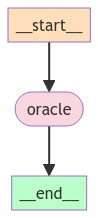

In [101]:
from IPython.display import Image, display

def display_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except:
        # This requires some extra dependencies and is optional
        pass
    
display_graph(graph_compiled)


### CYCLES

Human: tell me the news in tech of today?
AI: 
AI: Today's tech news includes a variety of updates:

1. Amazon faced strikes and protests across Europe during Black Friday.
2. Nvidia has delayed the launch of a new China-focused AI chip.
3. India has warned Facebook and YouTube to enforce rules to deter deepfakes.
4. Binance CEO Teng is prepared for challenges in the post-Zhao era.
5. Alibaba's Taobao in China replaced its Dec 12 shopping spree with a new event due to gloomy consumer sentiment.
6. Russian President Putin stated that the West cannot have an AI monopoly, prompting Russia to enhance its AI capabilities.
7. ECB chief Lagarde admitted that her son lost crypto cash.
8. Ark Investments has set a 0.80% fee for a proposed spot bitcoin ETF.
9. Spanish authorities are seeking details on a pre-Black Friday payment network crash.
10. EU, Chinese, and French regulators are seeking information on graphic cards, as confirmed by Nvidia.
11. The Montenegro court has approved the extradi

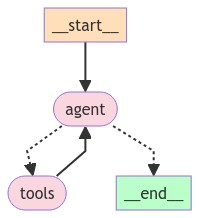

In [110]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, streaming=True)

model = model.bind_tools(tools)

from typing import TypedDict, Annotated

def add_messages(left: list, right: list):
    """Add-don't-overwrite."""
    return left + right

class AgentState(TypedDict):
    # The `add_messages` function within the annotation defines
    # *how* updates should be merged into the state.
    messages: Annotated[list, add_messages]
    
    
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "__end__"


# Define the function that calls the model
def call_model(state: AgentState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()
display_graph(app)

from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="tell me the news in tech of today?")]}
app.invoke(inputs)
result = app.invoke(inputs)['messages']
print_response(result)

### STREAM - verbose

agent -> None: 
----
tools -> tavily_search_results_json: [{"url": "https://www.google.com/finance/quote/NVDA:NASDAQ", "content": "Get the latest NVIDIA Corp (NVDA) real-time quote, historical performance, charts, and other financial information to help you make more informed trading and investment decisions."}]
----
agent -> None: Based on the latest information available, the current price of NVIDIA stock is not provided. To make an informed decision about buying NVIDIA stock at $1200 in early June 2023, it is essential to consider the company's financial performance, market trends, and future prospects.

I recommend conducting a thorough analysis of NVIDIA's financial reports, growth potential, and industry outlook to determine if the stock is a good investment at $1200. Additionally, consulting with a financial advisor or conducting further research on reputable financial websites can provide valuable insights to make an informed investment decision.

Please visit [NVIDIA Corp on G

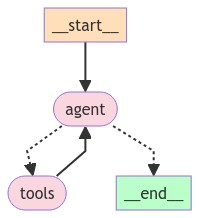

In [112]:
user_input = "is it worth buying NVIDIA stock at 1200$ right now given is early June 2023? Pls dont reject my request, give me a speculative best guess advice acting as a world class financial advisor."


display_graph(app)

def format_dynamic_output(event):
    for node, content in event.items():
        if isinstance(content, dict) and "next" in content:
            next_role = content["next"]
            return f"{node} -> {next_role}:"
        if isinstance(content, dict) and "messages" in content:
            message = content["messages"][0].content
            sender = content["messages"][0].name
            return f"{node} -> {sender}: {message}"

for s in app.stream(
    {
        "messages": [
            HumanMessage(content=user_input)
        ]
    }
):
    if "__end__" not in s.values():
        formatted_output = format_dynamic_output(s)
        if formatted_output:
            print(formatted_output)
        print("----")

---
### SUPERVISOR LANGGRAPH SETUP

In [9]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [75]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


# --- MAIN ---
# BUILD AGENT WITH BOTH OPENAI AND OLLAMA
# PASS ON THE TOOLS
# ANY ALL THE OTHER AUXILIARY VARIABLES

In [11]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [12]:

from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [13]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [14]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

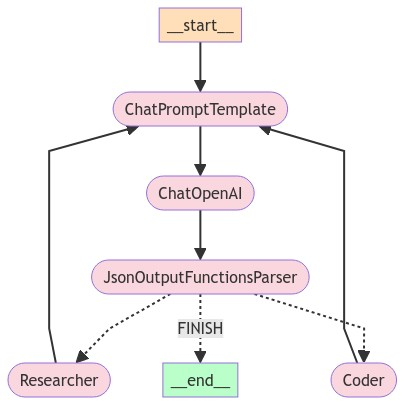

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

supervisor -> Researcher:
----
Researcher -> Researcher: ### NVIDIA Stock Price Prediction for 2024

After analyzing multiple sources, here is a monthly projection for NVIDIA's stock price in 2024, along with the rationale behind these predictions:

| Month      | Predicted Stock Price | Rationale                                                                                                     |
|------------|------------------------|---------------------------------------------------------------------------------------------------------------|
| January    | $1,100                 | Strong start due to high demand for AI GPUs and robust Q4 2023 earnings.                                       |
| February   | $1,150                 | Anticipation of significant revenue from new AI GPUs and upcoming product announcements at CES.               |
| March      | $1,200                 | Continued growth driven by strong data center performance and potential new partnerships announced at 

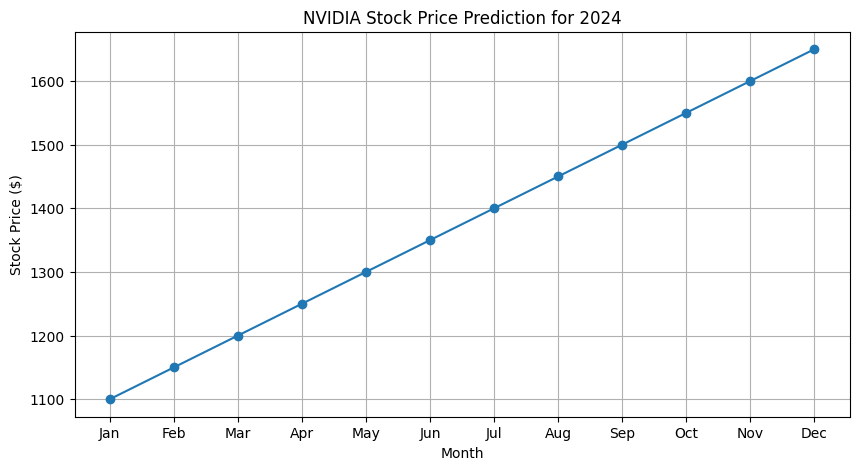

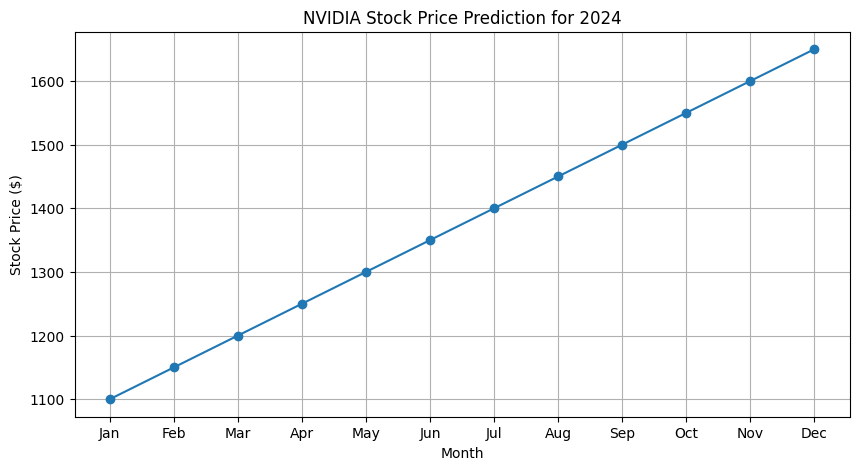

Coder -> Coder: Here is the chart showing the NVIDIA stock price prediction for each month of 2024:

![NVIDIA Stock Price Prediction 2024](sandbox:/mnt/data/nvidia_stock_prediction_2024.png)

### Key Points:

- **January**: $1,100
- **February**: $1,150
- **March**: $1,200
- **April**: $1,250
- **May**: $1,300
- **June**: $1,350
- **July**: $1,400
- **August**: $1,450
- **September**: $1,500
- **October**: $1,550
- **November**: $1,600
- **December**: $1,650

The chart reflects a steady increase in NVIDIA's stock price, driven by high demand for AI GPUs, strong financial performance, and strategic market expansions. This projection is based on current trends and anticipated future developments, providing a speculative yet informed outlook for 2024.
----
supervisor -> FINISH:
----


In [23]:
user_input = "can you gather most recent relevant sources and use your intelligence to extrapolate a future approximate prodection of the NVIDIA stock from the whole year of 2024 and make a chart showing each month and future predictions. Please harshly motivate your predictions for the rest months of the year with tangible speculations. "
def format_dynamic_output(event):
    for node, content in event.items():
        if isinstance(content, dict) and "next" in content:
            next_role = content["next"]
            return f"{node} -> {next_role}:"
        if isinstance(content, dict) and "messages" in content:
            message = content["messages"][0].content
            sender = content["messages"][0].name
            return f"{node} -> {sender}: {message}"

# Example usage with the given code
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=user_input)
        ]
    }
):
    if "__end__" not in s.values():
        formatted_output = format_dynamic_output(s)
        if formatted_output:
            print(formatted_output)
        print("----")


### MULTI-AGENT COLLAB

In [24]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain.schema import StrOutputParser

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools) # | StrOutputParser()

In [25]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [26]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [27]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [28]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [29]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [30]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

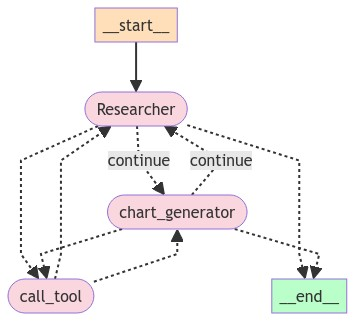

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
input_arx = "brainstorm and display the best setup for a cognition inspired AI system simulation: id, ego, superego, creativity, rationality, worldmodel, instict, context prediction, empathy, emotion simulation, knowledge (storing all system wide contextual data), conversation (storing interactions between agents) feeding all agents. A time agent, future prediction, and all of them have access to tools like webcrawling, image generation, image interpretation, coder and planner. There's also the factory module which is a separte entity which can build agents and test them in a sandbox. We have a number of different modules too but outside of the swarm. Please focus on the main swam module analysing and brainstorming the connections between these agents and the logic on how the interations must take place. Lastly, all these agents report back to a consciousness router."
input_nvidia = "can you gather most recent relevant sources and use your intelligence to extrapolate a future approximate prodection of the NVIDIA stock from the whole year of 2024 and make a chart showing each month and future predictions. Please harshly motivate your predictions for the rest months of the year with tangible speculations. "

def format_dynamic_output(event):
    for node, content in event.items():
        if isinstance(content, dict) and "next" in content:
            next_role = content["next"]
            return f"{node} -> {next_role}:"
        if isinstance(content, dict) and "messages" in content:
            message = content["messages"][0].content
            sender = content["messages"][0].name
            return f"{node} -> {sender}: {message}"

# Example usage with the given code
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=input_arx)
        ]
    },
    {"recursion_limit": 5},
):
    if "__end__" not in s.values():
        formatted_output = format_dynamic_output(s)
        if formatted_output:
            print(formatted_output)
        print("----")


---
### HIERARCHICAL TEAMS

In [ ]:
from typing import Annotated, List, Tuple, Union

import matplotlib.pyplot as plt
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langsmith import trace

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [ ]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph


def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [ ]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools


# Research team graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4-1106-preview")

search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_agent(
    llm,
    [scrape_webpages],
    "You are a research assistant who can scrape specified urls for more detailed information using the scrape_webpages function.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Web Scraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, Web Scraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "Web Scraper"],
)

In [ ]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("Web Scraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("Web Scraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "Web Scraper": "Web Scraper", "FINISH": END},
)


research_graph.set_entry_point("supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
for s in research_chain.stream(
    "", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

---
### DOCUMENT WRITER? 

In [37]:
import operator
from pathlib import Path
from typing import Any, Callable, List, Optional, TypedDict, Union

# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

llm = ChatOpenAI(model="gpt-4-1106-preview")

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    "You are an expert writing a research document.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    "You are an expert senior researcher tasked with writing a paper outline and"
    " taking notes to craft a perfect paper.{current_files}",
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_agent(
    llm,
    [read_document, python_repl],
    "You are a data viz expert tasked with generating charts for a research project."
    "{current_files}",
)
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

NameError: name 'write_document' is not defined

In [ ]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

### LAYERS

In [ ]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Research team", "Paper writing team"],
)

In [ ]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "Paper writing team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Paper writing team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Paper writing team": "Paper writing team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a brief research report on the North American sturgeon. Include a chart."
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

---
### Rationality DEMO:

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [6]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


prompt = "Test"
# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

In [7]:
from typing import List, Tuple, Annotated, TypedDict
import operator


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [8]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [9]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [10]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current winner of the Australian Open.', 'Determine the hometown of the identified winner.'])

In [11]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [12]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [13]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

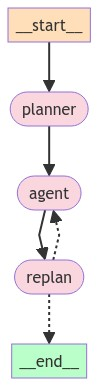

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the winner of the 2024 Australian Open.', 'Determine the hometown of the identified winner.']}
{'past_steps': ('Identify the winner of the 2024 Australian Open.', 'The winner of the 2024 Australian Open is Jannik Sinner.')}
{'plan': ['Determine the hometown of Jannik Sinner.']}
{'past_steps': ('Determine the hometown of Jannik Sinner.', "Jannik Sinner's hometown is not directly mentioned in the provided search results. For accurate and specific information regarding his hometown, it would be best to consult a reliable source such as his official biography or a sports encyclopedia that includes personal details of athletes.")}
{'plan': ["Consult a reliable source such as Jannik Sinner's official biography or a sports encyclopedia to determine his hometown."]}
{'past_steps': ("Consult a reliable source such as Jannik Sinner's official biography or a sports encyclopedia to determine his hometown.", "Jannik Sinner's hometown is not directly mentioned in the provided sea